# Self-Driving Car Engineer Nanodegree

## Project: Vehicle Detection and Tracking

This notebook is my attempt at Project #5. The goal of this project is to write a software pipeline to dentify vehicles in a video from a front-facing camera on a car. 

---
## Step 0: Import the Useful Packages

In [2]:
import numpy as np
import cv2
import csv
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from moviepy.editor import VideoFileClip
from IPython.display import HTML
import os
import imageio
imageio.plugins.ffmpeg.download()
%matplotlib inline
import sklearn
from sklearn.model_selection import train_test_split
from skimage.feature import hog
import collections
from sklearn.utils import shuffle

import time
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from scipy.ndimage.measurements import label

np.set_printoptions(threshold=np.nan)

---

## Step 1: Create the Dataset and Label

This is to label the data we were given.


In [3]:
#This opens a data.csv file that I created and adds the given examples of 'cars' and 'not-cars' to it
data_file = open("data.csv", 'w', newline='') #open the CSV I want to write to
writer = csv.writer(data_file)

for dirpath, dirnames, filenames in os.walk("vehicles"): #label all of the vehicle images 1
    for filename in filenames:
        fullPath = os.path.join(dirpath, filename)
        writer.writerow([fullPath, 1])

for dirpath, dirnames, filenames in os.walk("non-vehicles"): #label all of the non-vehicle images 0
    for filename in filenames:
        fullPath = os.path.join(dirpath, filename)
        writer.writerow([fullPath, 0])
        

---

## Step 2: Load the Dataset

This is to load the data we were given.


In [4]:
#This loads and splits my data into useable arrays
#array to hold the csv excel files created
lines = [] 

#open the data that was collected and store in lines
with open("data.csv") as csvfile:
    reader = csv.reader(csvfile)
    for line in reader:
        lines.append(line)

#arrays to store the image and their label
images = []
carOrNots = []

#load images and labels to arrays
for line in lines:
    source_path = line[0]
    image = cv2.imread(source_path)
    images.append(image)
    carOrNot = line[1]
    carOrNots.append(carOrNot)

#split up the data, use random in case I want to play with different training sets/is this a bad idea/
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(images, carOrNots, test_size=0.2, random_state=rand_state)  

#see how the split went
y_traincounts = collections.Counter(y_train)
y_testcounts = collections.Counter(y_test)

print(y_traincounts)
print(y_testcounts)


Counter({'0': 7033, '1': 7016})
Counter({'1': 1776, '0': 1737})


---

## Step 3: Choose and Train Colorspace and SVM. 

This is to pick a colorspace for my hog features to use. Just going to pick the best one after a few runs. Also, once I have a color space in place, I will do the same for an SVM (Linear or RBF probably). 


In [5]:
#Code taken and altered from lecture and quizes

# Define a function to return HOG features and visualization
def get_hog_features_chooseColor(img, orient, pix_per_cell, cell_per_block, feature_vec=True): #gets the hog features   
        features = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=True, feature_vector=feature_vec)
        return features

# Define a function to extract features from a list of images, for gray change to 0
def extract_features_chooseColor(imgs, cspace='RGB', orient=9, pix_per_cell=8, cell_per_block=2, hog_channel='ALL'):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        # Read in each one by one
        image = file
        # apply color conversion if other than 'RGB'
        if cspace != 'RGB':
            if cspace == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
            elif cspace == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_BGR2LUV)
            elif cspace == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_BGR2HLS)
            elif cspace == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_BGR2YUV)
            elif cspace == 'YCrCb': #change to gray
                feature_image = cv2.cvtColor(image, cv2.COLOR_BGR2YCrCb) #cv2.COLOR_BGR2YGRAY, 
        else: feature_image = np.copy(image)      

        # Call get_hog_features() with vis=False, feature_vec=True
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.append(get_hog_features_chooseColor(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, feature_vec=True))
            hog_features = np.ravel(hog_features)        
        else:
            hog_features = get_hog_features_chooseColor(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, feature_vec=True)
        # Append the new feature vector to the features list
        features.append(hog_features)
    # Return list of feature vectors
    return features


In [6]:
#Code taken and altered from lecture and quizes
#test my colorspace on basic linear svm with c=1, also track time
### TODO: Tweak these parameters and see how the results change.

#X_train, y_train = shuffle(X_train, y_train) #shuffle the training data
#I test the RGB, HSV, LUV, HLS, YUV, YCrCb colorspaces for which one might work the best
#use all channels and same orient, pix, and cell from lecture
orient = 9
pix_per_cell = 8
cell_per_block = 2
hog_channel = "ALL" # Can be 0, 1, 2, or "ALL"

#Test all by changing
colorspace = 'YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb

t=time.time()

X_trainHogs = extract_features_chooseColor(X_train, cspace=colorspace, orient=orient, 
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                        hog_channel=hog_channel)

X_testHogs = extract_features_chooseColor(X_test, cspace=colorspace, orient=orient, 
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                        hog_channel=hog_channel)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to extract HOG features...')



X = X_trainHogs
Xtester = X_testHogs
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)
X_scalertest = StandardScaler().fit(Xtester)
# Apply the scaler to X
scaled_X = X_scaler.transform(X)
scaled_Xtest = X_scalertest.transform(Xtester)

# Define the labels vector
y = y_train
ytest = y_test

X_trained = scaled_X
X_tested = scaled_Xtest

print('Using:',orient,'orientations',pix_per_cell,
    'pixels per cell and', cell_per_block,'cells per block')
print('Feature vector length:', len(X_trained[0]))
# Use a linear SVC or RBF
svc = LinearSVC(C=1)#SVC(C=10)#LinearSVC(C=1) #Change this to test
# Check the trainig time for the SVC
t=time.time()
svc.fit(X_trained, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_tested, ytest), 4))
# Check the prediction time for a single sample
t=time.time()
n_predict = 10
print('My SVC predicts: ', svc.predict(X_tested[0:n_predict]))
print('For these',n_predict, 'labels: ', ytest[0:n_predict])
t2 = time.time()
print(round(t2-t, 5), 'Seconds to predict', n_predict,'labels with SVC')

53.38 Seconds to extract HOG features...
Using: 9 orientations 8 pixels per cell and 2 cells per block
Feature vector length: 5292
12.73 Seconds to train SVC...
Test Accuracy of SVC =  0.9892
My SVC predicts:  ['0' '0' '1' '0' '0' '0' '0' '1' '0' '1']
For these 10 labels:  ['0', '0', '1', '0', '0', '0', '0', '1', '0', '1']
0.01201 Seconds to predict 10 labels with SVC


---

## Step 4: Visualize my Hog Features

Eyecandy for the writeup.


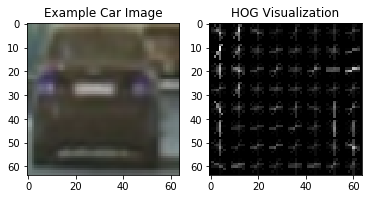

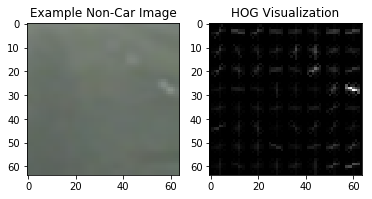

In [7]:
##Code taken and altered from lecture and quizes
#hog features/dispaly hog on car and non-car
img_car = cv2.imread('vehicles/GTI_MiddleClose/image0000.png')
img_noncar = cv2.imread('non-vehicles/GTI/image1.png')

# Define a function to return HOG features and visualization
def get_hog_featuresVis(img, orient, pix_per_cell, cell_per_block, vis=False, feature_vec=True, hog_channel=2):
    if vis == True:
        features, hog_image = hog(img[:,:,hog_channel], orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=False, 
                                  visualise=True, feature_vector=False)
        return features, hog_image
    else:      
        features = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=False, 
                       visualise=False, feature_vector=feature_vec)
        return features

# Define HOG parameters
orient = 9
pix_per_cell = 8
cell_per_block = 2

gray = cv2.cvtColor(img_car, cv2.COLOR_BGR2YCrCb)
features, hog_image = get_hog_featuresVis(gray, orient, pix_per_cell, cell_per_block, vis=True, feature_vec=False)


# Plot the examples
fig = plt.figure()
plt.subplot(121)
plt.imshow(img_car, cmap='gray')
plt.title('Example Car Image')
plt.subplot(122)
plt.imshow(hog_image, cmap='gray')
plt.title('HOG Visualization')

gray2 = cv2.cvtColor(img_noncar, cv2.COLOR_BGR2YCrCb)
features2, hog_image2 = get_hog_featuresVis(img_noncar, orient, pix_per_cell, cell_per_block, vis=True, feature_vec=False)

# Plot the examples
fig = plt.figure()
plt.subplot(121)
plt.imshow(img_noncar, cmap='gray')
plt.title('Example Non-Car Image')
plt.subplot(122)
plt.imshow(hog_image2, cmap='gray')
plt.title('HOG Visualization')

#print(features[0])
#print(features2)



---

## Step 5: Sliding Windows

Implement a sliding window search. 


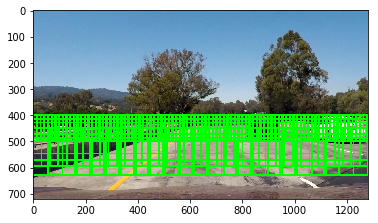

In [8]:
#Code taken and altered from lecture and quizes
#Slide a window
imagewindow = cv2.imread('test_images/test1.jpg')
imagewindow = cv2.cvtColor(imagewindow, cv2.COLOR_BGR2RGB)

# Here is your draw_boxes function from the previous exercise
# Here is your draw_boxes function from the previous exercise
def draw_boxes(img, bboxes, color, thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy
    
    
# Define a function that takes an image,
# start and stop positions in both x and y, 
# window size (x and y dimensions),  
# and overlap fraction (for both x and y)
def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    # Compute the span of the region to be searched    
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    # Compute the number of windows in x/y
    nx_buffer = np.int(xy_window[0]*(xy_overlap[0]))
    ny_buffer = np.int(xy_window[1]*(xy_overlap[1]))
    nx_windows = np.int((xspan-nx_buffer)/nx_pix_per_step) 
    ny_windows = np.int((yspan-ny_buffer)/ny_pix_per_step) 
    # Initialize a list to append window positions to
    window_list = []
    # Loop through finding x and y window positions
    # Note: you could vectorize this step, but in practice
    # you'll be considering windows one by one with your
    # classifier, so looping makes sense
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
    # Return the list of windows
    return window_list

windowssmall = slide_window(imagewindow, x_start_stop=[None, None], y_start_stop=[400, 500], 
                    xy_window=(72, 72), xy_overlap=(.8, .8))

windowsmed = slide_window(imagewindow, x_start_stop=[None, None], y_start_stop=[450, 600], 
                    xy_window=(128, 96), xy_overlap=(.75, .75))

windowslarge = slide_window(imagewindow, x_start_stop=[None, None], y_start_stop=[500, 650], 
                    xy_window=(160, 128), xy_overlap=(.65, .65))

windows = windowssmall + windowsmed + windowslarge
                       
window_img = draw_boxes(imagewindow, windows, color=(0, 255, 0), thick=6)                    
plt.imshow(window_img)

In [9]:
#Single image hog stuff
# Define a function to return HOG features and visualization
def get_hog_features(img, orient, pix_per_cell, cell_per_block, feature_vec=True): #gets the hog features   
        features = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=True, feature_vector=feature_vec)
        return features

# Define a function to extract features from a list of images
def extract_features(img, orient=9, pix_per_cell=8, cell_per_block=2):
    # Create a list to append feature vectors to
        # Call get_hog_features() with vis=False, feature_vec=True
    hog_features2 = []
    for channel in range(img.shape[2]):
        hog_features2.append(get_hog_features(img[:,:,channel], 
                                orient, pix_per_cell, cell_per_block, feature_vec=True))
    hog_features2 = np.ravel(hog_features2)        
        # Append the new feature vector to the features list
    # Return list of feature vectors
    return hog_features2

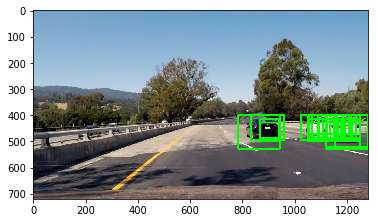

In [10]:
# Define a function you will pass an image 
# and the list of windows to be searched (output of slide_windows())
def search_windows(img, windows, clf, scaler, orient, pix_per_cell, cell_per_block, feature_vec=True):
    #1) Create an empty list to receive positive detection windows
    on_windows = []
    #2) Iterate over all windows in the list
    for window in windows:
        #3) Extract the test window from original image
        test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))
        test_img2 = cv2.cvtColor(test_img, cv2.COLOR_BGR2YCrCb)
        #4) Extract features for that window using single_img_features()
        HOGfeatures = extract_features(test_img2, orient, pix_per_cell, cell_per_block)
        #5) Scale extracted features to be fed to classifier
        # Fit a per-column scaler
        #X_scaler2 = StandardScaler().fit(HOGfeatures)
        # Apply the scaler to X
        test_features = scaler.transform(np.array(HOGfeatures).reshape(1, -1))#X_scaler2.transform(HOGfeatures)
        #6) Predict using your classifier
        predictionfactor = clf.decision_function(test_features)
        #prediction = int(predictionfactor > 0.5)
        #print(prediction)
        #7) If positive (prediction == 1) then save the window
        if predictionfactor > 0:
            on_windows.append(window)
    #8) Return windows for positive detections
    return on_windows




imagewindow = cv2.imread('test_images/test4.jpg')
drawsme = cv2.cvtColor(imagewindow, cv2.COLOR_BGR2RGB)


orient = 9
pix_per_cell = 16
cell_per_block = 1


windowssmall = slide_window(imagewindow, x_start_stop=[None, None], y_start_stop=[400, 500], 
                    xy_window=(72, 72), xy_overlap=(.8, .8))

windowsmed = slide_window(imagewindow, x_start_stop=[None, None], y_start_stop=[400, 600], 
                    xy_window=(128, 96), xy_overlap=(.75, .75))

windowslarge = slide_window(imagewindow, x_start_stop=[None, None], y_start_stop=[400, 600], 
                    xy_window=(160, 128), xy_overlap=(.65, .65))

#windowsxlarge = slide_window(imagewindow, x_start_stop=[None, None], y_start_stop=[400, 600], 
                    #xy_window=(160, 160), xy_overlap=(.8, .8))

windows =  windowssmall + windowsmed + windowslarge# + windowsxlarge
                       

hot_windows = search_windows(imagewindow, windows, svc, X_scaler, orient=orient, pix_per_cell=pix_per_cell, cell_per_block=cell_per_block)                       

window_img = draw_boxes(drawsme, hot_windows, color=(0, 255, 0), thick=6)                    



#plt.imshow(drawsme)
plt.imshow(window_img)


---

## Step 6: Testing and Improving the Sliding Windows

Implement a sliding window search with heat maps and tight bounding boxes. 


<class 'numpy.ndarray'>
are you sure
(720, 1280, 5)
(720, 1280)
(720, 1280)
(720, 1280, 2)
(720, 1280)


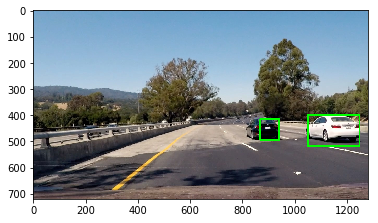

In [34]:
#Code taken and altered from lecture and quizes
from scipy.ndimage.measurements import label

# Read in image similar to one shown above 
imageforheat = cv2.imread('test_images/test4.jpg')
imageforheatRGB = cv2.cvtColor(imageforheat, cv2.COLOR_BGR2RGB)
heat = np.zeros_like(imageforheat[:,:,0]).astype(np.float)
box_list = hot_windows

def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap# Iterate through list of bboxes
    
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        height = bbox[1][1] - bbox[0][1]
        width = bbox[1][0] - bbox[0][0]
        #print(height, width)
        if height > 50  and width > 50:
            cv2.rectangle(img, bbox[0], bbox[1], (0,255,0), 6)
    # Return the image
    return img

# Add heat to each box in box list
heat = add_heat(heat,box_list)
    
# Apply threshold to help remove false positives
heat = apply_threshold(heat,2)

# Visualize the heatmap when displaying    
heatmap = np.clip(heat, 0, 255)

print(type(heatmap))
wtf = heatmap.shape

myarraytemp1 = np.zeros_like(heatmap)
myarraytemp2 = np.zeros_like(heatmap)
myAvgs = np.dstack((myarraytemp1, myarraytemp2))
my = np.zeros((wtf[0],wtf[1],5))

print("are you sure")

print(my.shape)


# Find final boxes from heatmap using label function
labels = label(heatmap)
draw_img = draw_labeled_bboxes(np.copy(imageforheatRGB), labels)

print(labels[0].shape)
#print(labels[1].shape)
yo = np.copy(labels[0])
print(yo.shape)
yo3 = np.stack((labels[0], yo), axis=2)
print(yo3.shape)
y04 = np.average(yo3, axis=2)
print(y04.shape)

plt.imshow(draw_img)
#fig = plt.figure()
#plt.subplot(121)
#plt.imshow(draw_img)
#plt.title('Car Positions')
#plt.subplot(122)
#plt.imshow(heatmap, cmap='hot')
#plt.title('Heat Map')
#fig.tight_layout()



In [ ]:
#Pipeline Functions
def slide_windowM(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    # Compute the span of the region to be searched    
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    # Compute the number of windows in x/y
    nx_buffer = np.int(xy_window[0]*(xy_overlap[0]))
    ny_buffer = np.int(xy_window[1]*(xy_overlap[1]))
    nx_windows = np.int((xspan-nx_buffer)/nx_pix_per_step) 
    ny_windows = np.int((yspan-ny_buffer)/ny_pix_per_step) 
    # Initialize a list to append window positions to
    window_list = []
    # Loop through finding x and y window positions
    # Note: you could vectorize this step, but in practice
    # you'll be considering windows one by one with your
    # classifier, so looping makes sense
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
    # Return the list of windows
    return window_list

def get_hog_featuresM(img, orient, pix_per_cell, cell_per_block, feature_vec=True): #gets the hog features   
        features = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=True, feature_vector=feature_vec)
        return features

# Define a function to extract features from a list of images
def extract_featuresM(img, orient=9, pix_per_cell=8, cell_per_block=2):
    # Create a list to append feature vectors to
        # Call get_hog_features() with vis=False, feature_vec=True
    hog_features2 = []
    for channel in range(img.shape[2]):
        hog_features2.append(get_hog_features(img[:,:,channel], 
                                orient, pix_per_cell, cell_per_block, feature_vec=True))
    hog_features2 = np.ravel(hog_features2)        
        # Append the new feature vector to the features list
    # Return list of feature vectors
    return hog_features2

def search_windowsM(img, windows, clf, scaler, orient, pix_per_cell, cell_per_block, feature_vec=True):
    #1) Create an empty list to receive positive detection windows
    on_windows = []
    #2) Iterate over all windows in the list
    for window in windows:
        #3) Extract the test window from original image
        test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))
        test_img2 = cv2.cvtColor(test_img, cv2.COLOR_BGR2YCrCb)
        #4) Extract features for that window using single_img_features()
        HOGfeatures = extract_features(test_img2, orient, pix_per_cell, cell_per_block)
        #5) Scale extracted features to be fed to classifier
        # Fit a per-column scaler
        #X_scaler2 = StandardScaler().fit(HOGfeatures)
        # Apply the scaler to X
        test_features = scaler.transform(np.array(HOGfeatures).reshape(1, -1))#X_scaler2.transform(HOGfeatures)
        #6) Predict using your classifier
        predictionfactor = clf.decision_function(test_features)
        prediction = int(predictionfactor > 0.80)
        #print(prediction)
        #7) If positive (prediction == 1) then save the window
        if prediction == '1':
            on_windows.append(window)
    #8) Return windows for positive detections
    return on_windows


def add_heatM(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap# Iterate through list of bboxes


def apply_thresholdM(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap


def draw_labeled_bboxesM(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        height = bbox[1][1] - bbox[0][1]
        width = bbox[1][0] - bbox[0][0]
        #print(height, width)
        if height > 50  and width > 50:
            cv2.rectangle(img, bbox[0], bbox[1], (0,255,0), 6)
    # Return the image
    return img